In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(dplyr)
options(repr.matrix.max.rows = 10)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
players_url <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"
download.file(players_url, "players.csv")
players <- read_csv("players.csv")

players_data <- select(players, experience, played_hours)

sessions_url <- "https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB"
download.file(sessions_url, "sessions.csv")
sessions <- read_csv("sessions.csv")

experience_data <- players_data |>
   mutate(experience_rank = case_when(
       experience == "Veteran" ~ 5,
       experience == "Pro" ~ 4,
       experience == "Regular" ~ 3,
       experience == "Amateur" ~ 2,
       experience == "Beginner" ~ 1,
       TRUE ~ NA_real_)) |>
   select(experience_rank, everything())
experience_data

set.seed(411)
players_split <- initial_split(experience_data, prop = 0.75, strata = played_hours)
players_training <- training(players_split)
players_testing <- testing(players_split)


Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience_rank,experience,played_hours
<dbl>,<chr>,<dbl>
4,Pro,30.3
5,Veteran,3.8
5,Veteran,0.0
2,Amateur,0.7
3,Regular,0.1
⋮,⋮,⋮
2,Amateur,0.0
5,Veteran,0.3
2,Amateur,0.0


In [3]:
set.seed(411)
players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("regression")

players_recipe <- recipe(played_hours ~ experience_rank, data = players_training) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

players_vfold <- vfold_cv(players_training, v = 5, strata = played_hours)

players_workflow <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(players_spec)

players_workflow


══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [16]:
set.seed(411)
players_gridvals <- tibble(neighbors = seq(1, 110, by = 2))

players_results <- players_workflow |>
   tune_grid(resamples = players_vfold, grid = players_gridvals) |>
   collect_metrics() |>
   filter(.metric == "rmse")

players_min <- players_results |>
    filter(mean == min(mean))
players_min

k_min <- players_min |>
   pull(neighbors)

players_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min)|>
  set_engine("kknn") |>
  set_mode("regression")

players_best_fit <- workflow() |>
   add_recipe(players_recipe) |>
   add_model(players_best_spec) |>
   fit(data = players_training)

players_rmse <- players_best_fit |>
  predict(players_testing) |>
  bind_cols(players_testing) |>
  metrics(truth = played_hours, estimate = .pred) |>
  filter(.metric == "rmse")
players_rmse


→ A | warning: A correlation computation is required, but `estimate` is constant and has 0
               standard deviation, resulting in a divide by 0 error. `NA` will be returned.

There were issues with some computations   A: x1

There were issues with some computations   A: x1





neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,26.83821,5,9.54339,Preprocessor1_Model01


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,5.461282


.pred,experience_rank,experience,played_hours
<dbl>,<dbl>,<chr>,<dbl>
0.0,5,Veteran,0.0
0.1,3,Regular,0.1
0.1,2,Amateur,0.0
0.1,2,Amateur,0.1
0.0,5,Veteran,0.0
⋮,⋮,⋮,⋮
0.0,5,Veteran,2.7
0.1,2,Amateur,2.1
0.1,2,Amateur,0.8


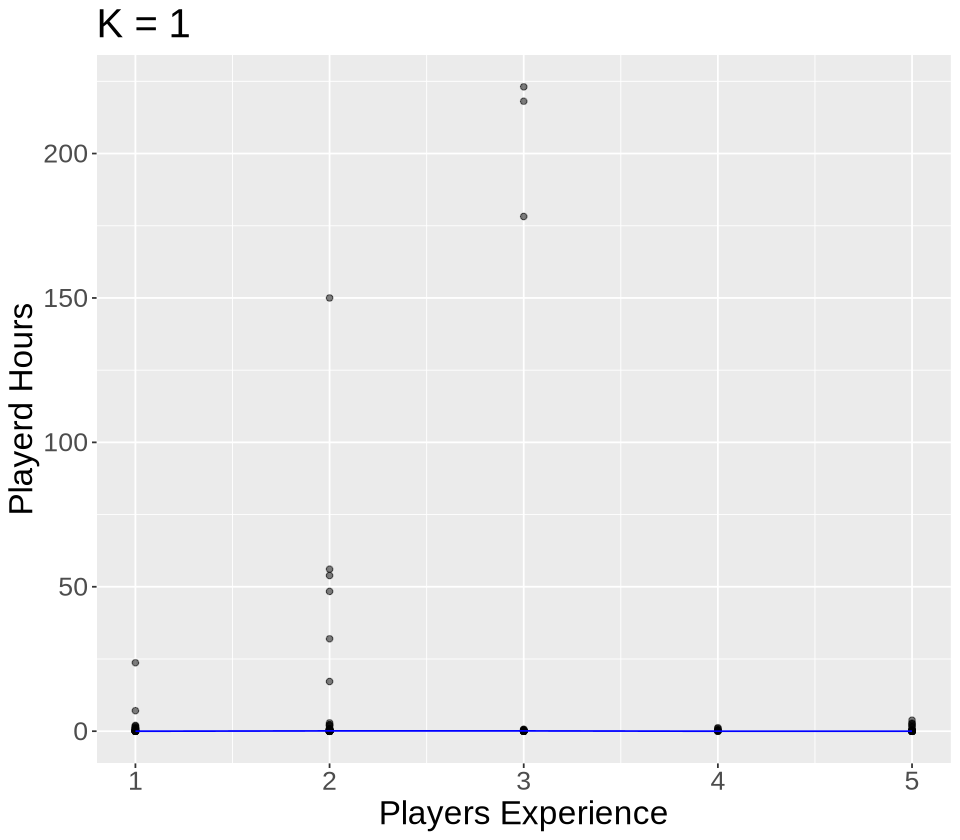

In [20]:
set.seed(411)
options(repr.plot.width = 8, repr.plot.height = 7)

players_preds <- players_best_fit |>
   predict(players_training) |>
   bind_cols(players_training)

players_preds

players_plot <- players_preds |>
  ggplot(aes(x = experience_rank, y = played_hours)) +
  geom_point(alpha = 0.5) +
  geom_line(data = players_preds, mapping = aes(x = experience_rank, y = .pred),
            color = "blue") +
  labs(x = "Players Experience",
       y = "Playerd Hours") +
   ggtitle(paste0("K = ", players_min)) +
  theme(text = element_text(size = 20))

players_plot